# estimate the sentiments in the documents
Calculate if the individual document are of positive or negative sentiment
additionally classify them into other categories of classifications

In [1]:
# Laod the libraries
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import spacy
import re
from  itertools import islice

sns.set_style('whitegrid')


nlp = spacy.load('fr_core_news_md')

In [2]:
# Load th eFeel Lexicon
lexicon = pd.read_csv('./Data/FEEL.csv',delimiter=';', index_col=0)
lexicon.head()

,word,polarity,joy,fear,sadness,anger,surprise,disgust
id,,,,,,,,
1,à ce endroit là,positive,0,0,0,0,0,0
2,à le hâte,negative,0,1,0,0,1,0
3,à part,negative,0,0,1,0,0,0
4,à pic,negative,0,1,0,0,0,0
5,à rallonge,negative,0,0,1,0,0,0


In [3]:
print("shape of the Feel Lexicon: ", lexicon.shape)

shape of the Feel Lexicon:  (14127, 8)


In [4]:
# Basic Statistics
lexicon.describe()

,joy,fear,sadness,anger,surprise,disgust
count,14127.000000,14127.000000,14127.000000,14127.000000,14127.000000,14127.000000
mean,0.036880,0.226446,0.177816,0.148864,0.083670,0.142493
std,0.188473,0.418546,0.382371,0.355967,0.276901,0.349568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Number of uniques in each column
lexicon.nunique()

word        14126
polarity        2
joy             2
fear            2
sadness         2
anger           2
surprise        2
disgust         2
dtype: int64

In [6]:
# Top ten words with highest value count
lexicon.word.value_counts().head(10)

bien                   2
paquet                 1
vendeur ambulant       1
berlin                 1
rossignol              1
médaille               1
peu satisfaisant       1
déclaration inexact    1
moucharder             1
souverain pontife      1
Name: word, dtype: int64

In [7]:
lexicon.word.value_counts().tail(10)

chiffre           1
four              1
se révolter       1
protester         1
spiral|spirale    1
embarras          1
soigner           1
infiniment        1
couvercle         1
compatible        1
Name: word, dtype: int64

In [8]:
lexicon[lexicon.word == 'bien']

,word,polarity,joy,fear,sadness,anger,surprise,disgust
id,,,,,,,,
147,bien,positive,1,0,0,0,0,0
2831,bien,positive,0,1,0,0,1,0


In [9]:
# Remove row with id'2831' 
lexicon= lexicon.drop(2831)

# Analyse Features in the Lexicon

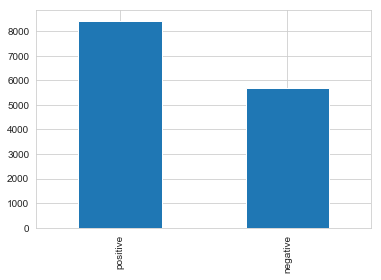

In [10]:
lexicon.polarity.value_counts().plot('bar');

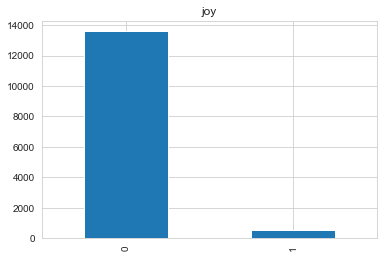

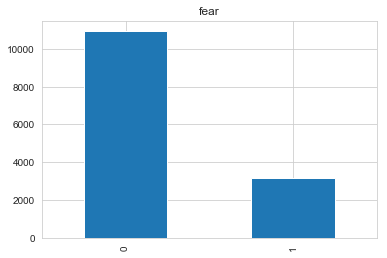

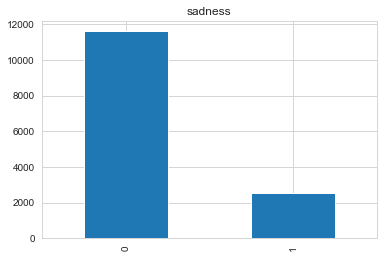

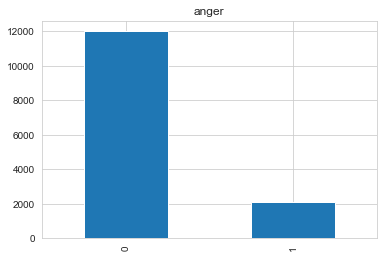

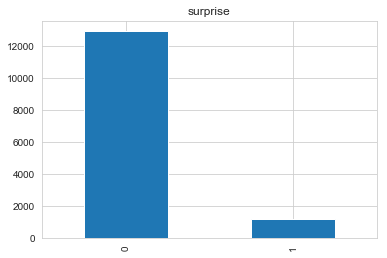

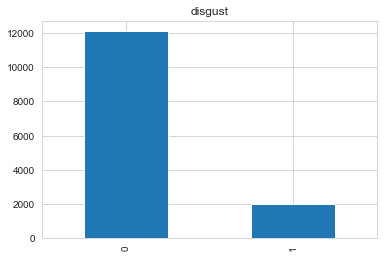

In [11]:
# Plot the distributions of all the emotions in the Feel Lexicon
for col in lexicon.columns[2:]:
    lexicon[col].value_counts().plot('bar', title=col)
    plt.show()

# Analyse Words

In [12]:
lexicon.word.head(10)

id
1     à ce endroit là
2           à le hâte
3              à part
4               à pic
5          à rallonge
6          abasourdir
7            ablation
8          abominable
9              abrupt
10             absent
Name: word, dtype: object

In [13]:
# Length of words
word_length = lexicon.word.str.split().apply(lambda lst: len(lst))

# Number of words grouped by length
word_length.value_counts()

1    11978
2     1306
3      657
4      141
5       29
6       15
Name: word, dtype: int64

In [14]:
#set Word as the index for the data set
lexicon = lexicon.set_index('word')
lexicon.head()

,polarity,joy,fear,sadness,anger,surprise,disgust
word,,,,,,,
à ce endroit là,positive,0,0,0,0,0,0
à le hâte,negative,0,1,0,0,1,0
à part,negative,0,0,1,0,0,0
à pic,negative,0,1,0,0,0,0
à rallonge,negative,0,0,1,0,0,0


# Load French tragedies Data

In [15]:
files = os.listdir('Data/FrenchTragedies/')

with sqlite3.connect('french_tragedies.db') as conn:
    curr = conn.cursor()
    curr.execute('DROP TABLE IF EXISTS French_Tragedies;')
    curr.execute('CREATE TABLE French_Tragedies(Filename text NOT NULL, Text text);')
    for filename in tqdm(files):
        with open('Data/FrenchTragedies/' + filename, encoding='utf-8') as file:
            text = file.read().replace('\n','')
            curr.execute('insert into French_Tragedies(Filename,Text) values (?,?);',(filename,text))
            

100%|██████████| 59/59 [00:00<00:00, 668.79it/s]


In [16]:
# Load as pandas dataframe
with sqlite3.connect('french_tragedies.db') as conn:
    french_data = pd.read_sql_query('Select * from French_Tragedies', conn)

In [17]:
french_data.head()

,Filename,Text
0,Crebillon_TR-V-1703-Idomenee.txt,"IDOMÉNÉE, TRAGÉDIE. CRÉBILL..."
1,Crebillon_TR-V-1707-Atree.txt,"ATRÉE et THYESTE, TRAGÉDIE. ..."
2,Crebillon_TR-V-1708-Electre.txt,"ÉLECTRE, TRAGÉDIE CRÉBILLON..."
3,Crebillon_TR-V-1711-Rhadamisthe.txt,"RHADAMISTHE et ZÉNOBIE, TRAGÉDIE ..."
4,Crebillon_TR-V-1717-Semiramis.txt,"SÉMIRAMIS, TRAGÉDIE CRÉBILL..."


# Approach 1

In [18]:
def window(seq, n=2):
    '''
    Returns a sliding window of width n over data from the iterable
    s-> (s0,s1,s2....s[n-1]),(s1,s2,s3,s4....)...

    
    '''
    it= iter(seq)
    result= tuple(islice(it,n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
    

def get_sentiment(sent):
    '''
    yields the sentiments of words found in the lexicon
    for each window of length 1 to 6 in  sent
    '''
    for window_size  in range(6,0, -1):
        # Search all the words of length window_size
        for each in window(sent.split(), window_size):
            sub_str = ' '.join(each)
            try:
                sentiment = lexicon.loc[sub_str]
                # remove that phrase so that we dont see it for smaller window
                sent.replace(sub_str, '')
                
                yield sentiment
            except KeyError:
                # if phrase not in lexicon ignore and continue
                pass
            
def gen_sentiments(text):
    '''
    Returns a pandas series containing sentiment count of the text

    '''
    text = ' '.join(text.split())
    # split the text on punctuations to get sentences
    sents = re.split(r'[,?!\.;:]', text)
    
    # sentments features to counts
    features= {
        'polarity_diff':0, # diff of positive and negative polarity
        'joy':0,
        'fear': 0,
        'sadness': 0,
        'anger': 0,
        'surprise': 0,
        'disgust': 0   
    }
    for sent in sents:
        for sentiment in get_sentiment(sent):
            if sentiment['polarity'] == 'positive':
                features['polarity_diff'] += 1
            else:
                # if the word is negative reduce the overall polarity
                features['polarity_diff'] -= 1
            features['joy'] += sentiment['joy']
            features['fear'] += sentiment['fear']
            features['sadness'] += sentiment['sadness']
            features['anger'] += sentiment['anger']
            features['surprise'] += sentiment['surprise']
            features['disgust'] += sentiment['disgust']
    return pd.Series(features)

In [19]:
sentiment_features = french_data['Text'].apply(gen_sentiments)

In [20]:
sentiment_features.head(15)

,polarity_diff,joy,fear,sadness,anger,surprise,disgust
0,172,108,805,771,694,216,589
1,416,130,694,648,581,225,555
2,354,149,795,743,571,218,532
3,366,107,623,568,572,200,466
4,570,154,667,611,520,247,435
5,522,173,712,720,589,234,525
6,573,145,732,647,636,242,545
7,619,156,763,752,622,238,543
8,593,150,637,616,518,216,498
9,642,159,629,640,543,213,485


In [21]:
sentiment_features.describe()

,polarity_diff,joy,fear,sadness,anger,surprise,disgust
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,656.813559,144.355932,595.627119,565.423729,474.762712,201.847458,451.423729
std,249.181244,36.262340,112.344283,109.550524,93.507576,39.354627,80.404195
min,172.000000,66.000000,331.000000,298.000000,273.000000,100.000000,230.000000
25%,501.000000,116.000000,530.000000,492.000000,418.000000,184.500000,407.500000
50%,605.000000,150.000000,608.000000,570.000000,465.000000,210.000000,457.000000
75%,784.500000,167.500000,672.000000,647.500000,542.500000,226.500000,494.500000
max,1304.000000,219.000000,805.000000,775.000000,694.000000,269.000000,628.000000


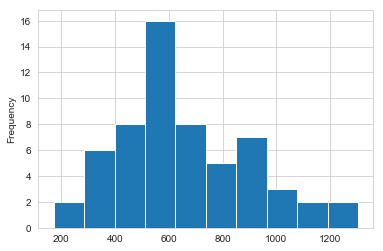

In [22]:
sentiment_features['polarity_diff'].plot('hist')

# Approach 2(Cleaned Text)

In [27]:
def cleaned_sentiment(text):
    doc = nlp(text)
    features = {
        'polarity_diff': 0, # diff. of positive and negative polarity
        'joy':0,
        'fear': 0,
        'sadness': 0,
        'anger': 0,
        'surprise': 0,
        'disgust': 0
        
    }
    for token in doc:
        # Lemmatize the word
        cleaned_token = token.lemma_
        try:
            sentiment = lexicon.loc[cleaned_token]
            if sentiment['polarity'] =='positive':
                features['polarity_diff'] += 1
            else:
                # if the word is negative, reduce the overall polarity
                features['polarity_diff'] -= 1
            features['joy'] += sentiment['joy']
            features['fear'] += sentiment['fear']
            features['sadness'] += sentiment['sadness']
            features['anger'] += sentiment['anger']
            features['surprise'] += sentiment['surprise']
            features['disgust'] += sentiment['disgust']
        except KeyError:
            pass
    return pd.Series(features)
                                

                

In [28]:
sentiment_features = french_data['Text'].apply(cleaned_sentiment)

In [29]:
sentiment_features.head(15)

,polarity_diff,joy,fear,sadness,anger,surprise,disgust
0,652,171,1396,1281,1074,397,1074
1,1007,191,1152,996,845,421,936
2,959,209,1275,1170,932,445,1007
3,854,146,1055,952,872,363,902
4,1296,208,1106,982,817,458,899
5,1183,249,1155,1106,897,439,1007
6,1278,212,1275,1098,1023,483,1080
7,1276,222,1276,1179,988,460,1116
8,1257,217,1070,1045,844,415,961
9,1277,234,1141,1088,924,418,1039


In [31]:
sentiment_features.describe()

,polarity_diff,joy,fear,sadness,anger,surprise,disgust
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,1356.186441,205.406780,1076.864407,987.220339,797.627119,420.949153,939.661017
std,393.830459,44.223616,173.257379,164.333037,136.927856,71.415352,146.132983
min,472.000000,95.000000,606.000000,525.000000,484.000000,211.000000,483.000000
25%,1096.500000,179.000000,973.500000,879.500000,702.500000,396.500000,881.500000
50%,1295.000000,210.000000,1106.000000,1015.000000,836.000000,421.000000,951.000000
75%,1598.000000,224.500000,1182.000000,1100.500000,888.000000,462.000000,1037.500000
max,2188.000000,295.000000,1396.000000,1281.000000,1074.000000,584.000000,1208.000000


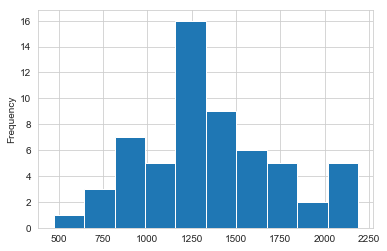

In [33]:
sentiment_features['polarity_diff'].plot('hist')

# Approach 3 Use omly adjectives and adverbs


In [37]:
def cleaned_sentiment(text):
    doc= nlp(text)
    features = {
        'polarity_diff': 0, # diff. of positive and negative polarity
        'joy':0,
        'fear': 0,
        'sadness': 0,
        'anger': 0,
        'surprise': 0,
        'disgust': 0        
    }
    for token in doc:
        # consider only those words which are detected as adjectives and adverbs
        if token.pos_ == 'ADV' or token.pos_ == 'ADJ':
            # taking the lemmatize text form
            cleaned_token = token.lemma_
            try:
                sentiment = lexicon.loc[cleaned_token]
                if sentiment['polarity'] == 'positive':
                    features['polarity_diff'] += 1
                else:
                    # if the word is negative reduce the overall polarity
                    features['polarity_diff'] -= 1
                features['joy'] += sentiment['joy']
                features['fear'] += sentiment['fear']
                features['sadness'] += sentiment['sadness']
                features['anger'] += sentiment['anger']
                features['surprise'] += sentiment['surprise']
                features['disgust'] += sentiment['disgust']
            except KeyError:
                pass
    return pd.Series(features)
    
    

In [38]:
sentiment_features = french_data['Text'].apply(cleaned_sentiment)

In [39]:
sentiment_features.head(15)


,polarity_diff,joy,fear,sadness,anger,surprise,disgust
0,-180,49,276,346,285,52,254
1,-49,54,181,252,180,53,197
2,-58,66,245,306,218,58,237
3,-102,40,214,261,246,48,257
4,-98,44,229,304,224,55,250
5,-24,57,229,305,224,60,252
6,-72,52,251,273,257,57,253
7,-97,77,275,364,290,62,292
8,-52,50,226,272,210,58,197
9,54,69,203,250,193,70,177


In [40]:
sentiment_features.describe()

,polarity_diff,joy,fear,sadness,anger,surprise,disgust
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,14.915254,64.949153,189.847458,234.135593,177.118644,55.440678,185.084746
std,83.665650,19.351044,47.805213,51.480983,48.468648,14.070354,45.412397
min,-180.000000,34.000000,90.000000,133.000000,96.000000,20.000000,111.000000
25%,-53.500000,48.500000,149.000000,196.000000,133.500000,47.000000,153.000000
50%,21.000000,65.000000,197.000000,233.000000,176.000000,57.000000,179.000000
75%,64.000000,76.500000,227.500000,259.500000,210.000000,63.500000,217.000000
max,216.000000,114.000000,278.000000,364.000000,290.000000,93.000000,292.000000


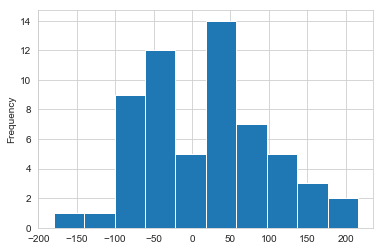

In [41]:
sentiment_features['polarity_diff'].plot('hist')

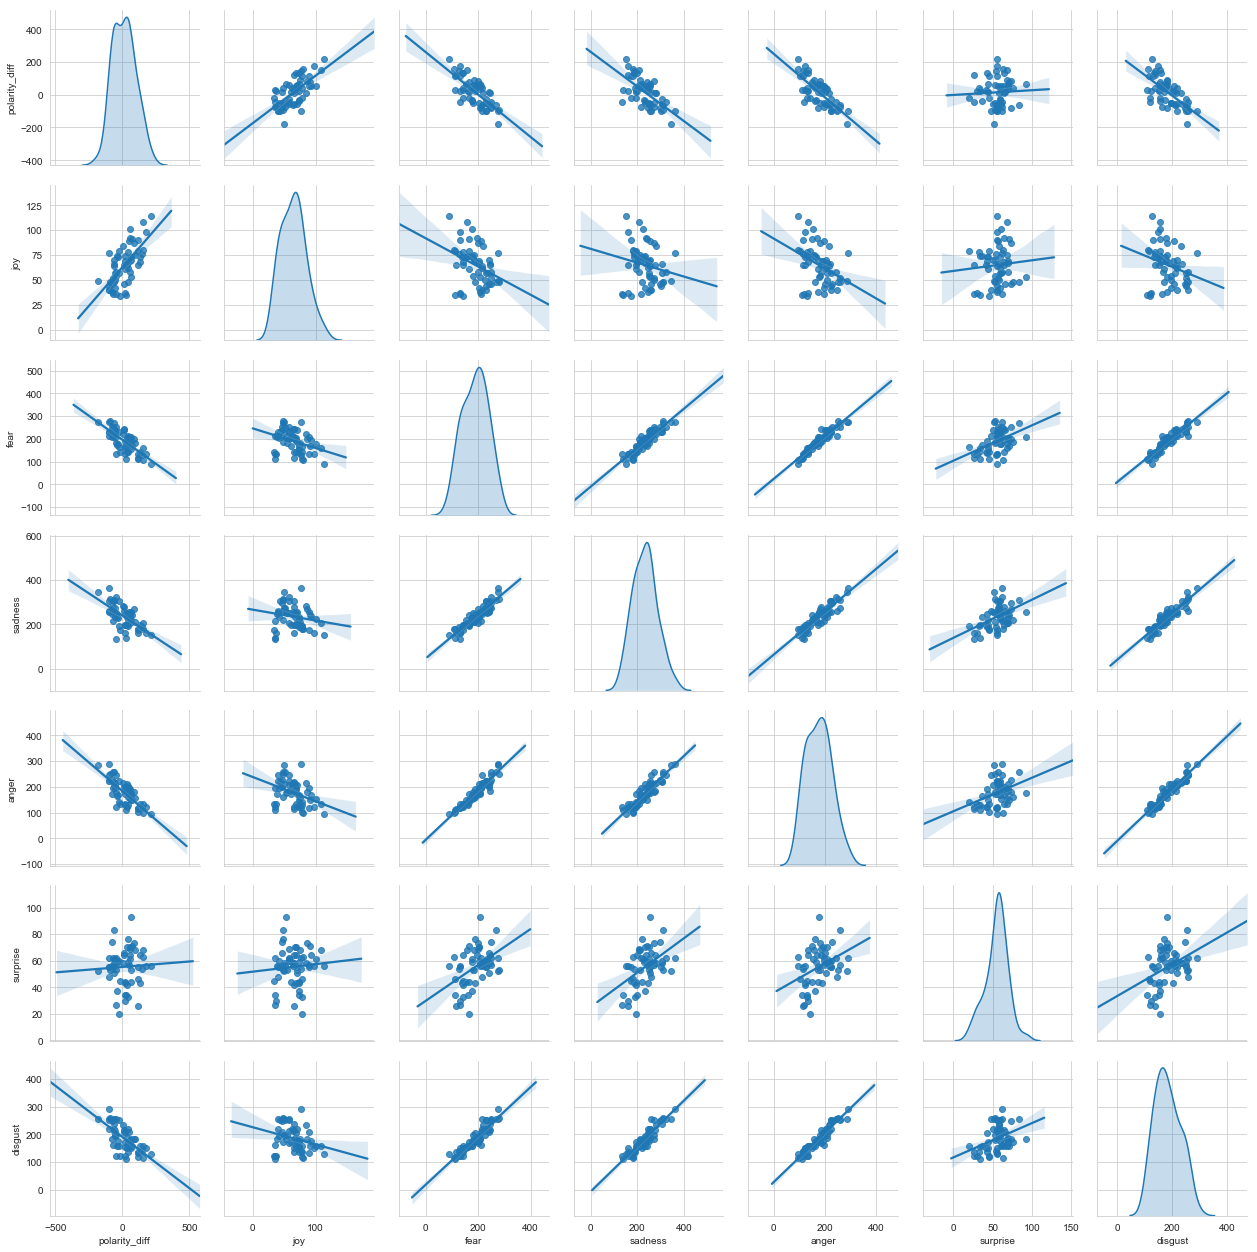

In [43]:
# Pair plots of all our sentiment features
sns.pairplot(sentiment_features, kind='reg', diag_kind='kde')

# Document Classification

In [45]:
# lets try to classify based on the polarity score of the stats  we obtained

from scipy.stats import percentileofscore


In [52]:
emotion_labels = ['joy','fear','sadness','anger','surprise','disgust']
def print_report(index):
    '''
    print polarity and emotion percentile bar graph
    compared to other document
    '''
    print('Document: ',french_data.loc[index]['Filename'])
    polarity= 'positive' if sentiment_features.loc[index]['polarity_diff'] > 0 else 'negative'
    print('Polarity: ',polarity)
    emotions = {}
    for label in emotion_labels:
        emotions[label] = percentileofscore(sentiment_features[label], sentiment_features.loc[index][label])
        
    # sort by values;highest value first
    emotions = pd.Series(emotions) # .sort_values()
    emotions.plot(kind='barh', xlim=(0,100));
    plt.show();
    

Document:  PCorneille_TR-V-1666-Agesilas.txt
Polarity:  positive


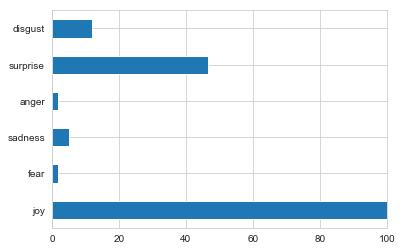

In [53]:
# Most positive document
index = sentiment_features['polarity_diff'].idxmax()
print_report(index)

Document:  Crebillon_TR-V-1703-Idomenee.txt
Polarity:  negative


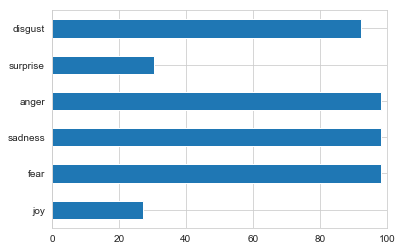

In [54]:
# Most negative document
index = sentiment_features['polarity_diff'].idxmin()
print_report(index)

# Sentiment and Emotion score for all the documents

Document:  Crebillon_TR-V-1703-Idomenee.txt
Polarity:  negative


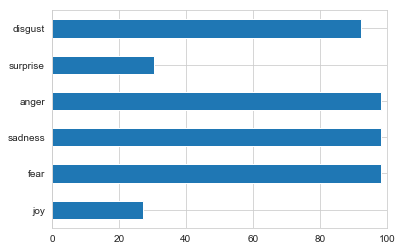

Document:  Crebillon_TR-V-1707-Atree.txt
Polarity:  negative


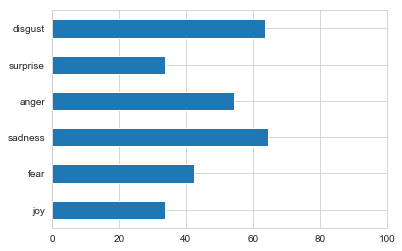

Document:  Crebillon_TR-V-1708-Electre.txt
Polarity:  negative


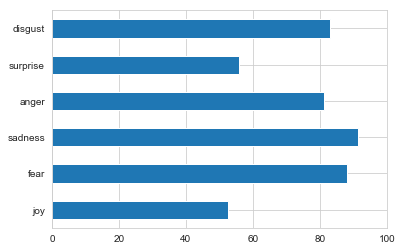

Document:  Crebillon_TR-V-1711-Rhadamisthe.txt
Polarity:  negative


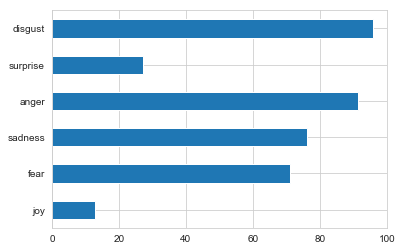

Document:  Crebillon_TR-V-1717-Semiramis.txt
Polarity:  negative


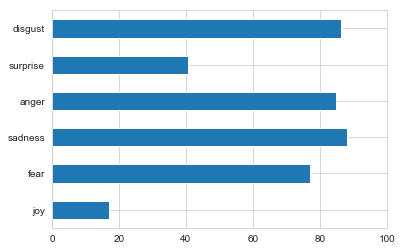

Document:  Crebillon_TR-V-1726-Pyrrhus.txt
Polarity:  negative


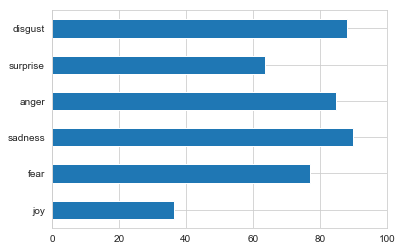

Document:  Crebillon_TR-V-1749-Catilina.txt
Polarity:  negative


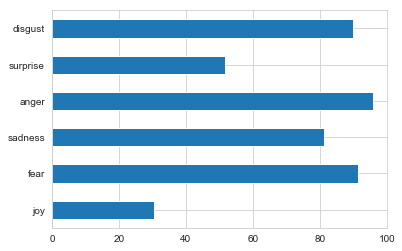

Document:  Crebillon_TR-V-1749-Xerces.txt
Polarity:  negative


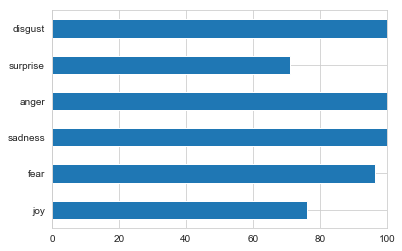

Document:  Crebillon_TR-V-1754-Triumvirat.txt
Polarity:  negative


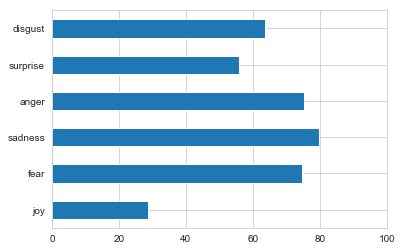

Document:  PCorneille_TR-V-1639-Medee.txt
Polarity:  positive


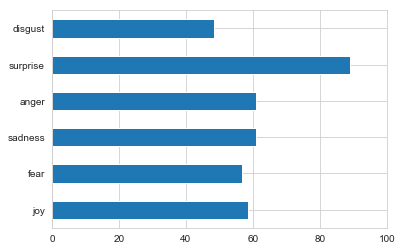

Document:  PCorneille_TR-V-1639-Nicomede.txt
Polarity:  positive


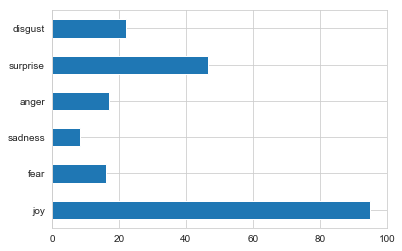

Document:  PCorneille_TR-V-1641-Horace.txt
Polarity:  positive


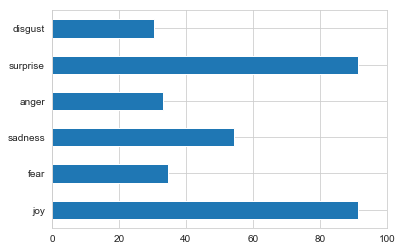

Document:  PCorneille_TR-V-1643-Cinna.txt
Polarity:  positive


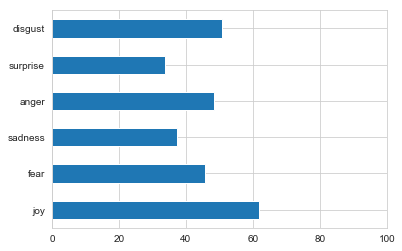

Document:  PCorneille_TR-V-1643-Polyeucte.txt
Polarity:  positive


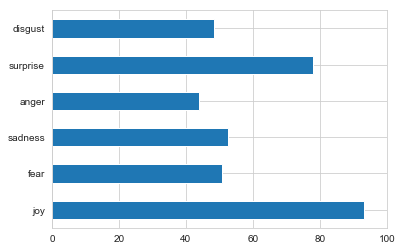

Document:  PCorneille_TR-V-1644-Pompee.txt
Polarity:  positive


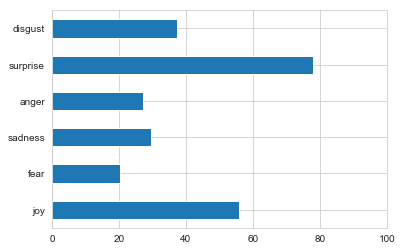

Document:  PCorneille_TR-V-1644-Rodogune.txt
Polarity:  positive


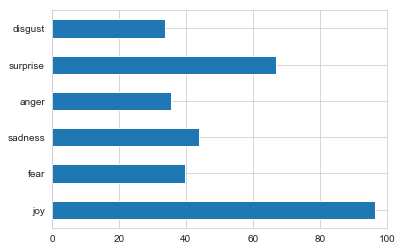

Document:  PCorneille_TR-V-1645-Theodore.txt
Polarity:  negative


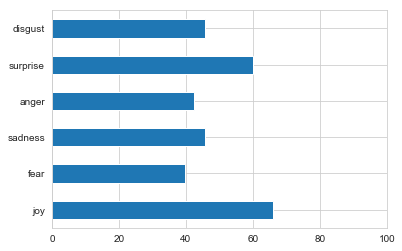

Document:  PCorneille_TR-V-1647-Heraclius.txt
Polarity:  positive


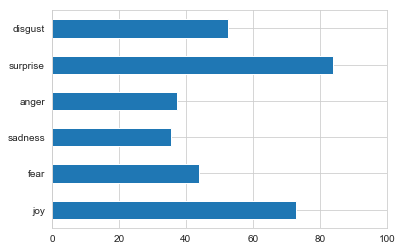

Document:  PCorneille_TR-V-1651-Andromede.txt
Polarity:  positive


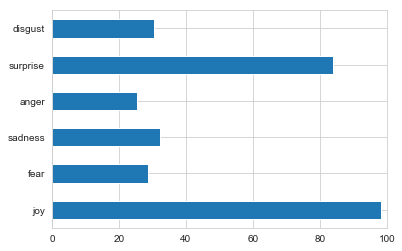

Document:  PCorneille_TR-V-1653-Pertharite.txt
Polarity:  positive


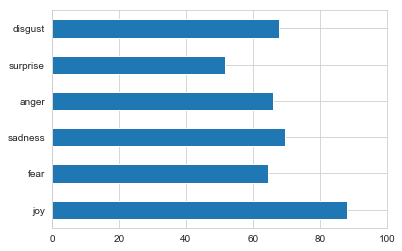

Document:  PCorneille_TR-V-1659-Oedipe.txt
Polarity:  positive


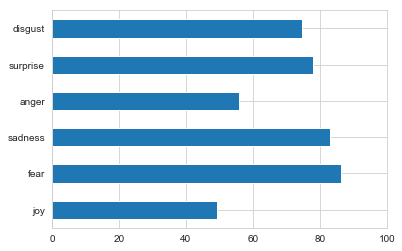

Document:  PCorneille_TR-V-1661-Toisondor.txt
Polarity:  positive


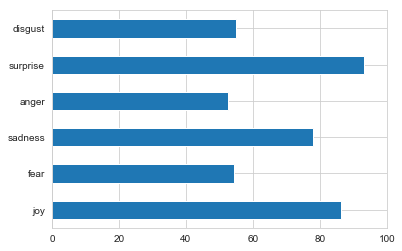

Document:  PCorneille_TR-V-1662-Sertorius.txt
Polarity:  positive


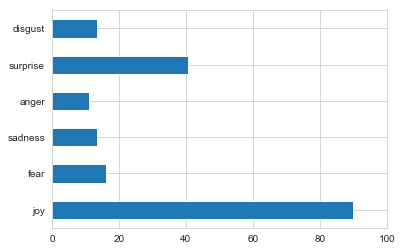

Document:  PCorneille_TR-V-1663-Sophonisbe.txt
Polarity:  positive


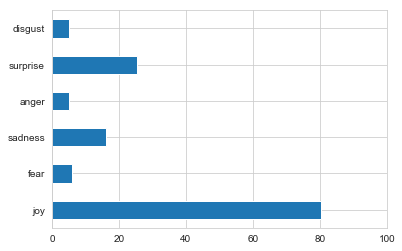

Document:  PCorneille_TR-V-1665-Othon.txt
Polarity:  positive


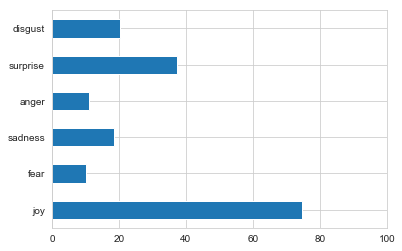

Document:  PCorneille_TR-V-1666-Agesilas.txt
Polarity:  positive


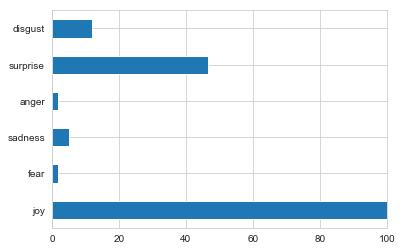

Document:  PCorneille_TR-V-1668-Attila.txt
Polarity:  positive


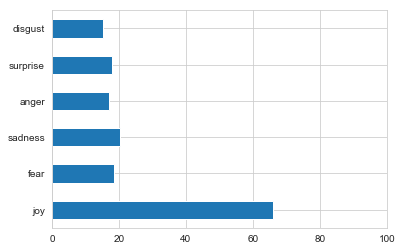

Document:  PCorneille_TR-V-1672-Pulcherie.txt
Polarity:  positive


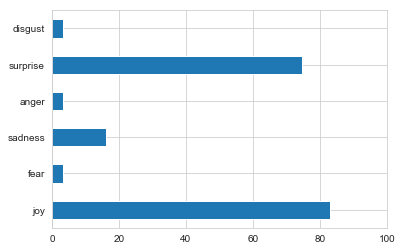

Document:  PCorneille_TR-V-1674-Surena.txt
Polarity:  positive


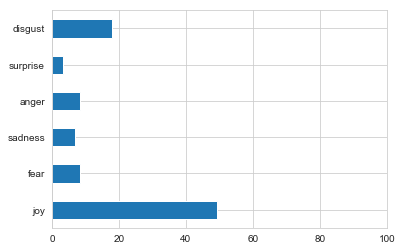

Document:  Racine_TR-V-1664-Thebaide.txt
Polarity:  negative


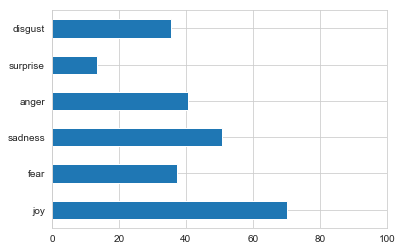

Document:  Racine_TR-V-1666-Alexandre.txt
Polarity:  positive


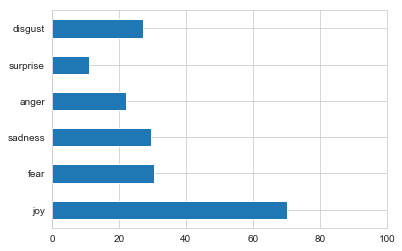

Document:  Racine_TR-V-1668-Andromaque.txt
Polarity:  negative


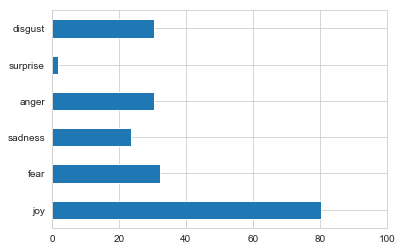

Document:  Racine_TR-V-1670-Britannicus.txt
Polarity:  positive


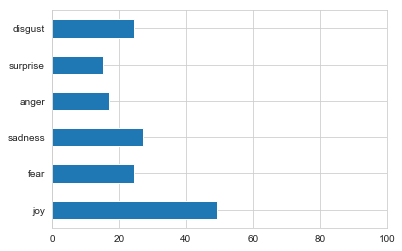

Document:  Racine_TR-V-1671-Berenice.txt
Polarity:  positive


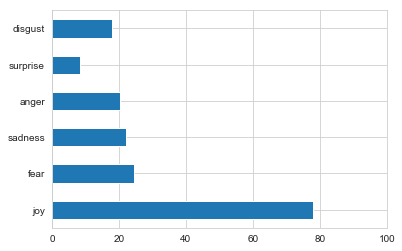

Document:  Racine_TR-V-1672-Bajazet.txt
Polarity:  positive


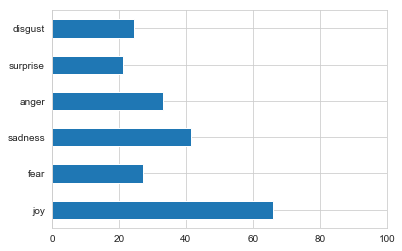

Document:  Racine_TR-V-1673-Mithridate.txt
Polarity:  positive


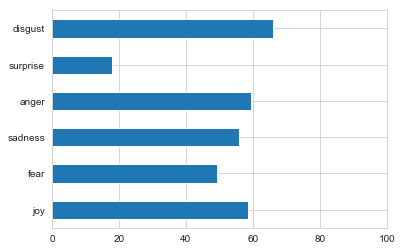

Document:  Racine_TR-V-1674-Iphigenie.txt
Polarity:  negative


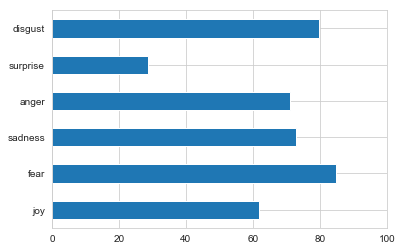

Document:  Racine_TR-V-1677-Phedre.txt
Polarity:  negative


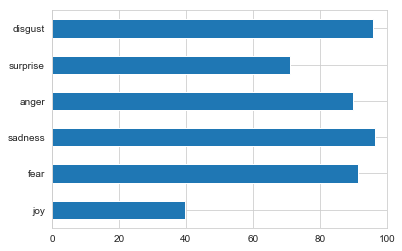

Document:  Racine_TR-V-1689-Esther.txt
Polarity:  positive


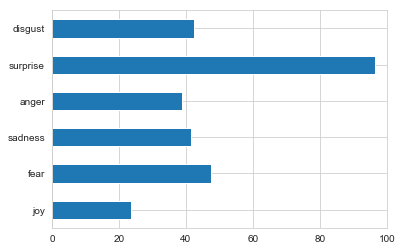

Document:  Racine_TR-V-1691-Athalie.txt
Polarity:  positive


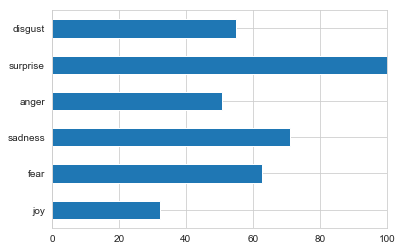

Document:  Voltaire_TR-V-1718-Oedipe.txt
Polarity:  negative


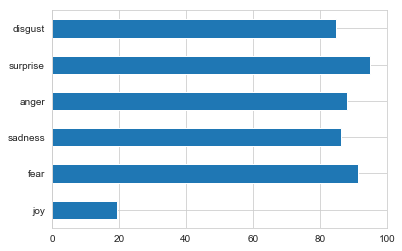

Document:  Voltaire_TR-V-1724-Mariamne.txt
Polarity:  negative


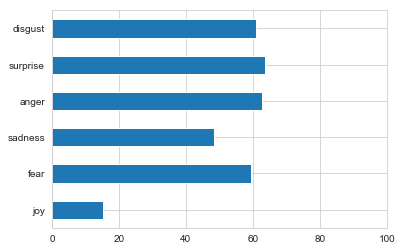

Document:  Voltaire_TR-V-1730-Brutus.txt
Polarity:  positive


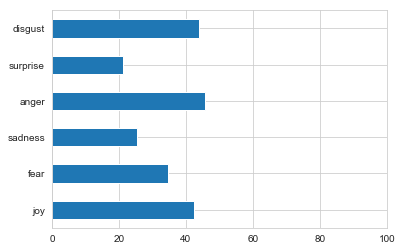

Document:  Voltaire_TR-V-1732-Alzire.txt
Polarity:  negative


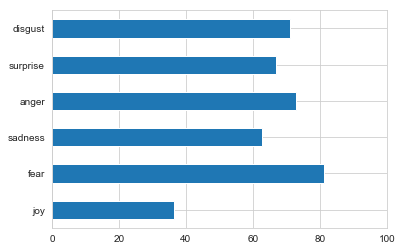

Document:  Voltaire_TR-V-1732-Zaire.txt
Polarity:  positive


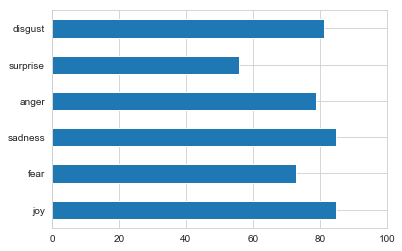

Document:  Voltaire_TR-V-1734-Agathocle.txt
Polarity:  negative


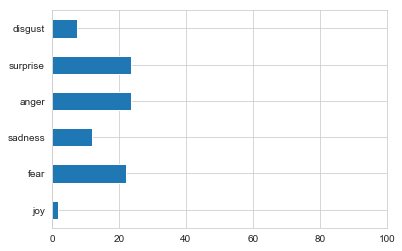

Document:  Voltaire_TR-V-1741-Fanatisme.txt
Polarity:  positive


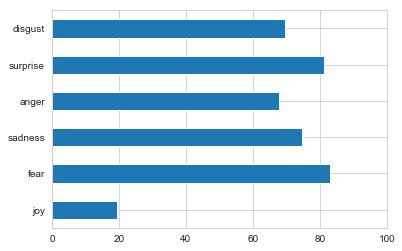

Document:  Voltaire_TR-V-1743-Merope.txt
Polarity:  negative


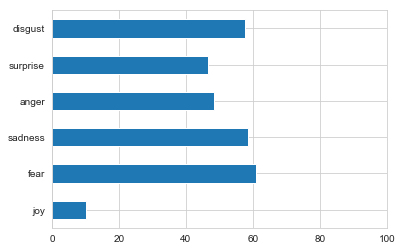

Document:  Voltaire_TR-V-1743-MortCesar.txt
Polarity:  positive


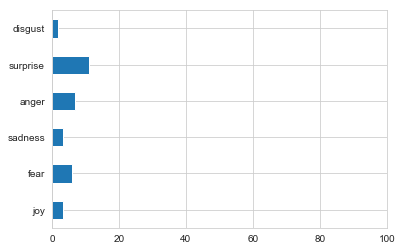

Document:  Voltaire_TR-V-1749-LoisMinos.txt
Polarity:  positive


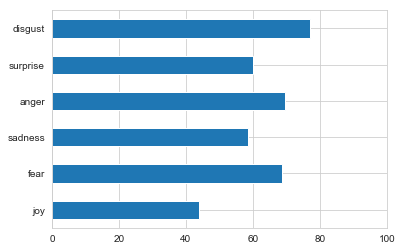

Document:  Voltaire_TR-V-1750-RomeSauvee.txt
Polarity:  positive


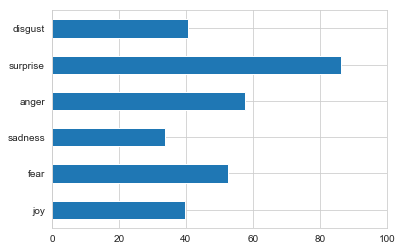

Document:  Voltaire_TR-V-1751-DucDAlencon.txt
Polarity:  negative


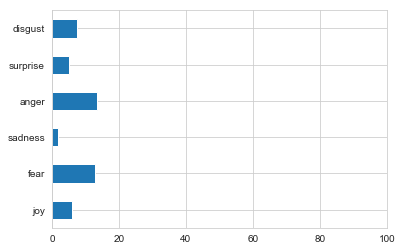

Document:  Voltaire_TR-V-1755-OrphelinChine.txt
Polarity:  negative


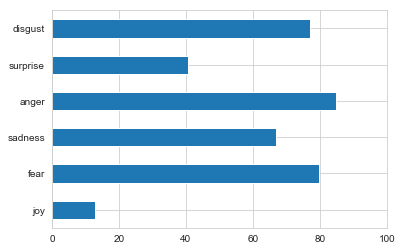

Document:  Voltaire_TR-V-1764-Olympie.txt
Polarity:  positive


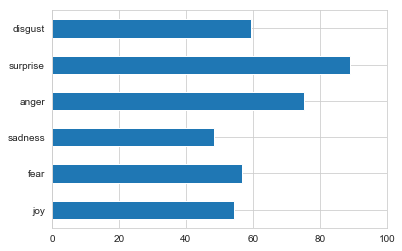

Document:  Voltaire_TR-V-1766-AdelaideDuGuesclin.txt
Polarity:  negative


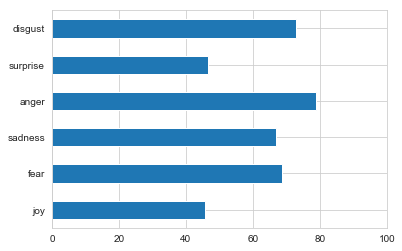

Document:  Voltaire_TR-V-1769-Guebres.txt
Polarity:  negative


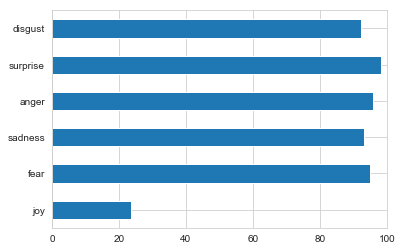

Document:  Voltaire_TR-V-1771-Tancrede.txt
Polarity:  negative


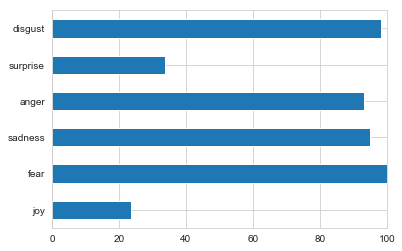

Document:  Voltaire_TR-V-1774-Sophonisbee.txt
Polarity:  positive


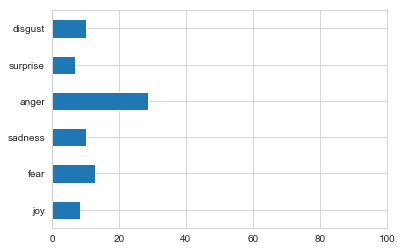

Document:  Voltaire_TR-V-1778-Irene.txt
Polarity:  negative


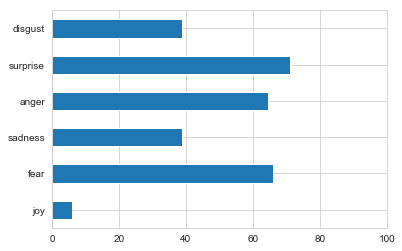

In [55]:
for index in range(len(french_data)):
    print_report(index)
    print('='*60)